<font color='darkblue' size=6> Multi Objective Optimization </font>

## What is Multi-objective decision making mean ?

* In many business problems, solutions have to be chosen based on not single objective but multiple objectives. For example, 

**Ranking:**
      - Relevance vs Diversity vs dispersion metric
**Alternative Accommodation ranking:**
      - Boost AA metrics [listing->detail CTR, Conversion ratio or room-night share of AA vs others], and
      - Maintain on improve overall city metrics [listing->detail CTR, CR etc]
**High Opportunity hotel auto-boosting:**
      - Boost chosen hotel cluster metrics [RN, CR or listing-> detail CTR]
      - Maintain or improve overall city metrics [CR, GR-SP etc..]





## Scenarios: 
**Trivial --** 
- Consider simple case of 2 objectives 
     - Each objective A and B is highly positively correlated, i.e. if we pick a point with max value on axis A, and that would be maximum on axis B too.

**Non-trivial -- **:
- No single solution exists that simultaneously optimizes each objective
- Optimizing for one means settling for less on another objective





## Options: 
Often when multiple objectives/reward are ought to be maximized with decisions, decision makers (DM) choose to compute a simple average based on importance DM gives to each objective/reward. Through this process, one converts the problem into single trivial objective. 


While it is the most popular method followed due to it's simplicity, it might not always yield expected results. 

**For example, consider situations where variation of reward 1 across choices is much higher than variation of reward 2 across choices. **

- For example, consider choices - A, B, C , D and E. 
     - Reward 1 varies between 0 to 500 [500 units]
     - Reward 2 varies between 150 to 170 [20 units]
     - DM chose to give equal weight to reward 1 and 2. Computes, "combined reward" and chooses a decision that gives maximum combined reward. 

While apriori weights intend to give equal importance to reward 1 and 2 in choosing a decision,  most of the variation in combined reward is driven by reward 1. So chosen decision may or may not be very favorable w.r.t. reward 2. 


Alternatives proposed in literature
-  Scalarization methods
     - linear 
     - non-linear (for ex Chebyshev scalarization reward)
     
-  Pareto Dominant regret/reward frontier 



**Pareto Optimal Non-dominated Frontier **
- There exists a (possibly infinite) , nondominated, Pareto optimal solutions.
- None of the objectives can be improved in value without degrading some of the other objective values – points on pareto frontier.
- All pareto optimal solutions are “equally good” , unless problem specific information is available to “trade-off”

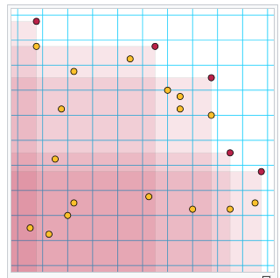



## Below notebook describes ::
- ** How to identify pareto frontier points**
- ** Combine it with Thompson sampling (MO-MAB - TS)**


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import io, os, sys, datetime, math, random, boto3, pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import ticker
#import tqdm.tqdm_pandas as tqdm_pandas
from tqdm.auto import tqdm
import copy

In [3]:
pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',200)
pd.set_option('display.width',500)

In [4]:
sns.set()
tqdm.pandas()

<font color='darkblue' size=6> Identify Pareto points with simulated_rewardpoints </font>

In [13]:
NUM_ARMS = 10
NUM_Rewards = 2

pts = np.random.multivariate_normal([0.4, 0.6], [[1,0.5],[0.5, 1]], size=NUM_ARMS)
pts = pd.DataFrame(pts, columns=['rew_'+str(i) for i in np.arange(NUM_Rewards) ])
pts.sort_values(by=['rew_0','rew_1'],ascending=[False, False], inplace=True)
pts.reset_index(inplace=True)
pts

,index,rew_0,rew_1
0,8,1.33,0.43
1,1,1.15,0.17
2,6,0.93,1.63
3,0,0.49,1.03
4,7,0.39,0.68
5,4,0.16,0.87
6,3,0.02,1.31
7,2,-0.78,-0.60
8,9,-0.95,-0.88
9,5,-1.25,-0.34


In [14]:
def flag_paretopts(pts):
    pareto_point = np.zeros(len(pts))
    pareto_sets = {}
    pcounter = 0
    for i, r in pts.iterrows():
        if i ==0:
            pareto_point[i] =1
            pareto_sets[pcounter] = {0:r['rew_0'], 1: r['rew_1']}
            pcounter +=1
        else:
            dominated = 0
            for rset in pareto_sets.values():
                if (r['rew_0'] < rset[0])&(r['rew_1'] < rset[1]):
                     dominated = 1
            if dominated ==1:
                pareto_point[i] = 0
            else:
                pareto_point[i] = 1
                pareto_sets[pcounter] = {0:r['rew_0'], 1: r['rew_1']}
                pcounter +=1
    pts['pareto_point'] = pareto_point  
    return pareto_sets, pts

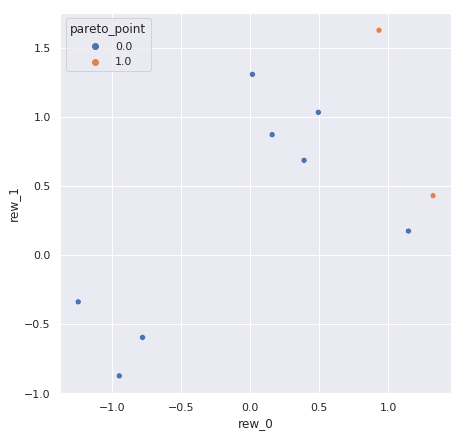

In [15]:
_s, pts = flag_paretopts(pts)
fig, ax = plt.subplots(1,1, figsize=(7,7))
sns.scatterplot(data=pts,x='rew_0', y='rew_1', ax=ax, hue='pareto_point')

<font color='darkblue' size=6> Multi-Objective MAB </font>

<font color='darkblue' size=6> Take above logic,  find pareto [non-dominated] arms and apply on top of MAB sampled points </font>

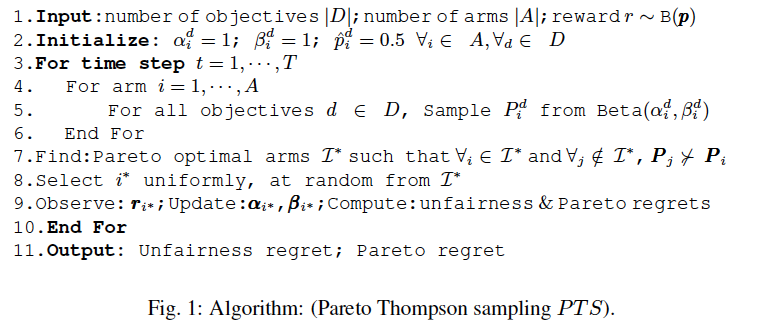

### Thompson sampling

In [16]:
from scipy.stats import beta

class ThompsonSampling():
    def __init__(self, counts, values, alpha, beta):
        self.counts = counts
        self.values = values
        
        # Beta parameters
        self.alpha = alpha
        self.beta = beta

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        # Uniform distribution of prior beta (A,B)
        self.alpha = [1 for arm in range(n_arms)]
        self.beta = [1 for arm in range(n_arms)]
    
    # Thompson Sampling
    def sample_from_betaDist(self):
        n_arms = len(self.counts)
        
        # Pair up all beta params of a and b for each arm
        beta_params = zip(self.alpha, self.beta)
        
        # Perform random draw for all arms based on their params (a,b)
        all_draws = [beta.rvs(i[0], i[1], size = 1) for i in beta_params]
        
        # return index of arm with the highest draw
        return all_draws #all_draws.index(max(all_draws))
    
    # Choose to update chosen arm and reward
    def update(self, chosen_arm, reward):
        # update counts pulled for chosen arm
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n                       = self.counts[chosen_arm]
        
        # Update average/mean value/reward for chosen arm
        value                   = self.values[chosen_arm]
        new_value               = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        
        # Update a and b
        
        # a is based on total counts of rewards of arm
        self.alpha[chosen_arm]  = self.alpha[chosen_arm] + reward
        
        # b is based on total counts of failed rewards on arm
        self.beta[chosen_arm]   = self.beta[chosen_arm] + (1-reward)

In [17]:
def test_algorithm(revalgo1, arms1, revalgo2, arms2, num_sims, horizon):
    
    # Initialise variables for duration of accumulated simulation (num_sims * horizon_per_simulation)
    
    chosen_arms, rewards, cumulative_rewards, sim_nums, times= [],[],[],[],[]
    for i in [0,1]:
        chosen_arms.append([0.0 for i in range(num_sims * horizon)])
        rewards.append([0.0 for i in range(num_sims * horizon)])
        cumulative_rewards.append([0 for i in range(num_sims * horizon)])
        sim_nums.append([0.0 for i in range(num_sims *horizon)])
        times.append([0.0 for i in range (num_sims*horizon)])
    
    for sim in tqdm(range(num_sims)):
        sim = sim + 1
        revalgo1.initialize(len(arms1))
        revalgo2.initialize(len(arms2))
        
        for t in range(horizon):
            t               = t + 1
            index           = (sim -1) * horizon + t -1
            sim_nums[0][index] = sim
            times[0][index]    = t
            # sample 
            draws1          = revalgo1.sample_from_betaDist()
            draws2          = revalgo2.sample_from_betaDist()
            pts             = pd.DataFrame(np.hstack((np.expand_dims(np.arange(len(draws1)),1 ), 
                                                    np.vstack(draws1), 
                                                    np.vstack(draws2))),columns=['armnum','rew_0','rew_1'])
            pts.sort_values(by=['rew_0','rew_1'],ascending=[False, False], inplace=True)
            pts         = pts.reset_index()
            _s, pts     = flag_paretopts(pts)
            pareto_arms =  pts.loc[pts.pareto_point>0,:]['armnum'].tolist()
            if len(pareto_arms)==1:
                chosen_arm = int(pareto_arms[0])
            else:
                chosen_arm = int(np.random.choice(pareto_arms,size=1,replace=False)[0])
            chosen_arms[0][index] = chosen_arm

            # Engage chosen Bernoulli Arm and obtain reward info
            rlist = []
            rlist.append(arms1[chosen_arm].draw())
            rlist.append(arms2[chosen_arm].draw())
            rewards[0][index] = rlist[0]
            rewards[1][index] = rlist[1]
            if t == 1:
                for i in [0,1]:
                    cumulative_rewards[i][index] = rlist[i]
            else:
                for i in [0,1]:
                    cumulative_rewards[i][index] = cumulative_rewards[i][index-1] + rlist[i]
            revalgo1.update(chosen_arm, rlist[0])
            revalgo2.update(chosen_arm, rlist[1])
    
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

### simulation

In [18]:
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    
    # Reward system based on Bernoulli
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

### Simulate

In [19]:
def simulate(hndlr1, hndlr2):
    means,  n_arms, arms= [], [], []
    means.append([0.1, 0.2, 0.5, 0.1, 0.9])
    means.append([0.2, 0.2, 0.1, 0.5, 0.6])
    for i in [0,1]:
        n_arms.append(len(means[i]))
        random.shuffle(means[i])
        arms.append(list(map(lambda mu: BernoulliArm(mu), means[i])))
    hndlr1.initialize(n_arms[0])
    hndlr2.initialize(n_arms[1])
    #
    results        = test_algorithm(hndlr1, arms[0], hndlr2, arms[1], 500, 250)
    return process_res_regrets(results)
    
def process_res_regrets(results):
    df             = pd.DataFrame()
    df['sim_nums'] = results[0][0]
    df['times']    = results[1][0]
    df['chosen_arm1']  = results[2][0]
    df['chosen_arm2']  = results[2][1]
    df['rewards1']     = results[3][0]
    df['rewards2']     = results[3][1]
    df['cum_rewards1'] = results[4][0]
    df['cum_rewards2'] = results[4][1]
    df1               = df.groupby('times').agg({'cum_rewards1': 'mean', 'cum_rewards2': 'mean'})
    #df1.plot(title='Cumulative Reward')
    df2list = []
    rlistnm = ['rewards1','rewards2']
    for i in [0,1]:
        _df2 = df.pivot_table(index=['times'], columns=rlistnm[i], aggfunc='size', fill_value=0)
        _df2.columns          = ['penalty', 'reward']
        _df2['prob_best_arm'] = _df2['reward']/(_df2['reward']+_df2['penalty'])
        df2list.append(_df2)
    return df, df1, df2list     
    
    #df2.plot(y='prob_best_arm', title='Probability Selecting best arm')

### Thompson Sampling Simulation

In [20]:
%%time
rew1_algo = ThompsonSampling([], [], [], [])
rew2_algo = ThompsonSampling([], [], [], [])
df, df1, df2list = simulate(rew1_algo, rew2_algo)



CPU times: user 16min 31s, sys: 6.07 s, total: 16min 37s
Wall time: 16min 31s


In [24]:
print(f"df.shape - {df.shape}")
df.head()

df.shape - (125000, 8)


,sim_nums,times,chosen_arm1,chosen_arm2,rewards1,rewards2,cum_rewards1,cum_rewards2
0,1,1,0,0.00,1.00,0.00,1.00,0.00
1,1,2,4,0.00,0.00,1.00,1.00,1.00
2,1,3,3,0.00,1.00,0.00,2.00,1.00
3,1,4,3,0.00,0.00,0.00,2.00,1.00
4,1,5,2,0.00,1.00,1.00,3.00,2.00


In [25]:
print(f"df1.shape - {df1.shape}")
df1.head()

df1.shape - (250, 2)


,cum_rewards1,cum_rewards2
times,,
1,0.39,0.32
2,0.75,0.64
3,1.14,0.94
4,1.59,1.31
5,2.05,1.66


In [26]:
print(f"df2list[0].shape - {df2list[0].shape}")
df2list[0].head()

df2list[0].shape - (250, 3)


,penalty,reward,prob_best_arm
times,,,
1,304,196,0.39
2,319,181,0.36
3,308,192,0.38
4,276,224,0.45
5,270,230,0.46


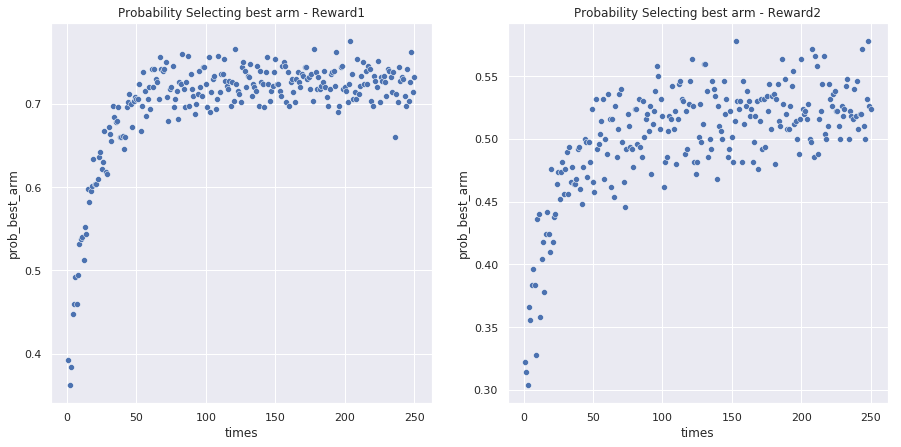

In [27]:
titlelist = ['Probability Selecting best arm - Reward'+str(i+1) for i in np.arange(2)] 
fig, ax = plt.subplots(1,2,figsize=(15,7))
for i in [0,1]:
    sns.scatterplot(data=df2list[i],x='times', y='prob_best_arm', 
                    ax=ax[i])
    ax[i].set_title(titlelist[i])

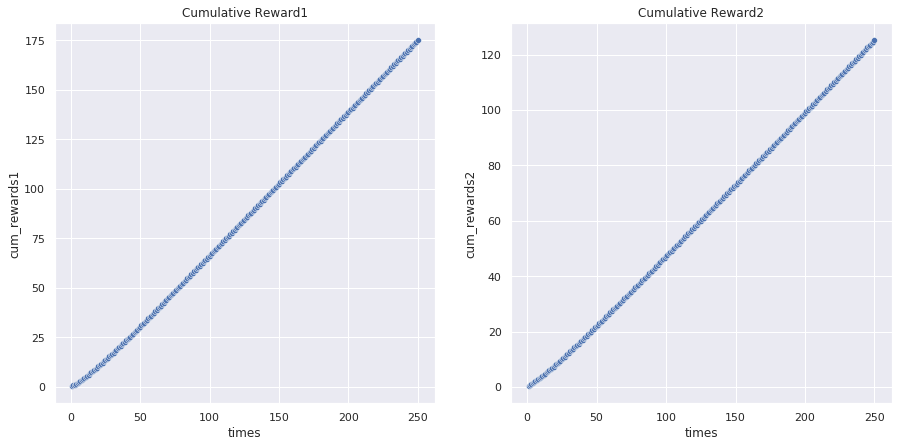

In [28]:
titlelist = ['Cumulative Reward'+str(i+1) for i in np.arange(2)] 
fig, ax = plt.subplots(1,2,figsize=(15,7))
for i in [0,1]:
    sns.scatterplot(data=df1,x='times', y='cum_rewards'+str(i+1), 
                    ax=ax[i])
    ax[i].set_title(titlelist[i])

## References

1. https://en.wikipedia.org/wiki/Pareto_efficiency

2. https://en.wikipedia.org/wiki/Maxima_of_a_point_set

3. Thompson Sampling for Multi-Objective Multi-Armed Bandits Problem
https://www.researchgate.net/publication/272823659_Thompson_Sampling_for_Multi-Objective_Multi-Armed_Bandits_Problem

4. Designing Multi-objective MAB algorithms: A study
https://www.researchgate.net/publication/236480059_Designing_multi-objective_multi-armed_bandits_algorithms_A_study?enrichId=rgreq-088e12391f5888b25c15bbc6a8cf288a-XXX&enrichSource=Y292ZXJQYWdlOzIzNjQ4MDA1OTtBUzoxMDMwNzk3ODk3Mjc3NDhAMTQwMTU4NzU0NTMyMA%3D%3D&el=1_x_3&_esc=publicationCoverPdf

